In [1]:
from typing import Any, Union
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas.io.parsers import TextFileReader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Importing the dataset
dat: Union[Union[TextFileReader, type, DataFrame], Any] = pd.read_csv("Skill.csv")
dat = dat[dat['TotalHours'] < 5000]
X = dat.iloc[:, 1:19].values
y = dat.iloc[:, 0].values

# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# all the models

names = (
    "Perceptron",
    "LogisticRegression",
    "SVC",
    "Decision Tree",
    "Random Forest",
    "RBF SVM",
    "Neural Net",
    "Naive Bayes",
    "Nearest Neighbors"
)

classifiers = (
    Perceptron(max_iter=5, tol=None),
    LogisticRegression(),
    SVC(C=100),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    SVC(kernel='rbf', gamma=2, C=1),
    MLPClassifier(hidden_layer_sizes=(100, 50), alpha=1),
    GaussianNB(),
    KNeighborsClassifier(5)
)

score_list = []
np.random.seed(0)


def run_pipe1(name, clf):
    pipe = Pipeline([('clf', clf)])
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    print("Algo: {0:<20s} and Score: {1:0.4f}".format(name, score))
    score_list.append(score)
    print(' ')
    index = int(np.argmax(score_list))
    print(f'{names[index]} performed the best with accuracy {max(score_list):0.4f}')
    return name, score


# Add PCA
def run_pipe2(name, clf):
    pipe = Pipeline([('pca', PCA(n_components=4)), ('clf', clf)])
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    print(f"Algo: {name:<20s} and Score: {score:0.4f}")
    return name, score


# 10-fold cross_validation
def get_cvscore(name, clf):
    scores = cross_val_score(clf, X, y, cv=10)
    print(f"Algo: {name:<20s} and Score: {np.mean(scores):0.4f}")
    return name, np.mean(scores)


d_pipe1 = dict(map(run_pipe1, names, classifiers))
d_pipe2 = dict(map(run_pipe2, names, classifiers))
d_cv = dict(map(get_cvscore, names, classifiers))


def get_modstats(name, clf):
    pipe: Pipeline = Pipeline([('pca', PCA(n_components=5)), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    prec = precision_score(y_true=y_test, y_pred=y_pred)
    rec = recall_score(y_true=y_test, y_pred=y_pred)
    print(name)
    return name, confmat, f1, prec, rec


l_modelstats = list(map(get_modstats, names, classifiers))
pd.DataFrame(l_modelstats, columns=("Algorithm",
                                    "Confusion_Matrix",
                                    "F1", "Precision",
                                    "Recall")).astype("object")

Algo: Perceptron           and Score: 0.7404
 
Perceptron performed the best with accuracy 0.7404
Algo: LogisticRegression   and Score: 0.8041
 
LogisticRegression performed the best with accuracy 0.8041
Algo: SVC                  and Score: 0.7440
 
LogisticRegression performed the best with accuracy 0.8041
Algo: Decision Tree        and Score: 0.7596
 
LogisticRegression performed the best with accuracy 0.8041
Algo: Random Forest        and Score: 0.8041
 
LogisticRegression performed the best with accuracy 0.8041
Algo: RBF SVM              and Score: 0.5733
 
LogisticRegression performed the best with accuracy 0.8041
Algo: Neural Net           and Score: 0.8125
 
Neural Net performed the best with accuracy 0.8125
Algo: Naive Bayes          and Score: 0.7837
 
Neural Net performed the best with accuracy 0.8125
Algo: Nearest Neighbors    and Score: 0.7620
 
Neural Net performed the best with accuracy 0.8125
Algo: Perceptron           and Score: 0.7260
Algo: LogisticRegression   and Sc

,Algorithm,Confusion_Matrix,F1,Precision,Recall
0,Perceptron,"[[413, 64], [161, 194]]",0.632953,0.751938,0.546479
1,LogisticRegression,"[[403, 74], [87, 268]]",0.76901,0.783626,0.75493
2,SVC,"[[385, 92], [114, 241]]",0.700581,0.723724,0.678873
3,Decision Tree,"[[402, 75], [106, 249]]",0.733432,0.768519,0.701408
4,Random Forest,"[[393, 84], [93, 262]]",0.747504,0.757225,0.738028
5,RBF SVM,"[[357, 120], [90, 265]]",0.716216,0.688312,0.746479
6,Neural Net,"[[403, 74], [94, 261]]",0.756522,0.779104,0.735211
7,Naive Bayes,"[[409, 68], [108, 247]]",0.737313,0.784127,0.695775
8,Nearest Neighbors,"[[378, 99], [100, 255]]",0.719323,0.720339,0.71831


In [3]:
# Employ GridSearchCV() to find the optimal parameters for SVC's kernel = 'rbf',
def gs_svc(c_param, gamma_param):
    print('Grid search for SVC')
    pipe = Pipeline([('scl', StandardScaler()), ('clf', SVC())])
    pipe.fit(X_train, y_train)  # <- note that pipe line inherits clf methods
    print(pipe.score(X_test, y_test))  # notably .fit(), .predict() and .score()
    params = {'clf__kernel': ['rbf'], 'clf__C': c_param, 'clf__gamma': gamma_param}
    grid = GridSearchCV(estimator=pipe, param_grid=params, cv=3)
    grid.fit(X_train, y_train)
    print('Best estimator:', grid.best_estimator_)
    print('Best training score:', grid.best_score_)
    print('Best testing score:', grid.score(X_test, y_test))
    print('Best parameter(s):', grid.best_params_)
    return grid.best_score_, grid.score(X_test, y_test), grid.best_params_


c = [0.01, 1, 10, 100]
gamma = [0.001, 0.01, 0.1, 1.0, 100.0]
best_svc = gs_svc(c, gamma)


# nested cross-validation svc
def get_score(pipe, params):
    gs = GridSearchCV(estimator=pipe, param_grid=params, scoring='accuracy', cv=2)
    scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
    print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return np.mean(scores), np.std(scores)


pipeline = Pipeline([('scl', StandardScaler()), ('clf', SVC())])
parameters = {'clf__kernel': ['rbf'], 'clf__C': c, 'clf__gamma': gamma}
svc_mean = get_score(pipeline, parameters)


# Employ GridSearchCV() to find the optimal parameters for DecisionTreeClassifier
def gs_dtc(based_on):
    print('Grid search for DecisionTree')
    c_list = [5, 10, 15, 20, 25, 30]
    pipe = Pipeline([('scl', StandardScaler()), ('clf', DecisionTreeClassifier())])
    params = {'clf__max_depth': c_list}
    grid = GridSearchCV(estimator=pipe, param_grid=params, scoring=based_on, cv=3)
    grid.fit(X_train, y_train)
    print("Score based on:", based_on)
    print('Best training score:', grid.best_score_)
    print('Best testing score:', grid.score(X_test, y_test))
    print('Best parameter(s):', grid.best_params_)
    return based_on, grid.best_score_, grid.score(X_test, y_test), grid.best_params_


score_types = ['accuracy', 'roc_auc', 'f1']
t_dtc = tuple(map(gs_dtc, score_types))

pipeline = Pipeline([('scl', StandardScaler()), ('clf', DecisionTreeClassifier())])
parameters = {'clf__max_depth': [5, 10, 15, 20, 25, 30]}
dtc_mean = get_score(pipeline, parameters)

# Employ GridSearchCV() to find the optimal parameters for RandomForestClassifier
c = [5, 7, 9, 11]
n_estimators = [90, 95, 100, 105]
max_features = [1, 3, 5, 7]


def gs_rfc(based_on):
    print('Grid search for Random Forest')
    pipe = Pipeline([('scl', StandardScaler()), ('clf', RandomForestClassifier())])
    params = {'clf__max_depth': [5, 7, 9, 11],
              'clf__n_estimators': [90, 95, 100, 105],
              'clf__max_features': [1, 3, 5, 7]
              }
    grid = GridSearchCV(estimator=pipe, param_grid=params, scoring=based_on, cv=3)
    grid.fit(X_train, y_train)
    print("Score based on:", based_on)
    print('Best training score:', grid.best_score_)
    print('Best testing score:', grid.score(X_test, y_test))
    print('Best parameter(s):', grid.best_params_)
    return based_on, grid.best_score_, grid.score(X_test, y_test), grid.best_params_


score_types = ['accuracy', 'roc_auc', 'f1']
t_rfc = tuple(map(gs_rfc, score_types))

pipeline = Pipeline([('scl', StandardScaler()), ('clf', RandomForestClassifier())])
parameters = {'clf__max_depth': [5, 7, 9, 11],
              'clf__n_estimators': [90, 95, 100, 105],
              'clf__max_features': [1, 3, 5, 7]
              }
rfc_mean = get_score(pipeline, parameters)


# Employ GridSearchCV() to find the optimal parameters for KNN
def gs_knc(based_on):
    print('Grid search for KNN')
    pipe = Pipeline([('scl', StandardScaler()), ('clf', KNeighborsClassifier())])
    params = {'clf__n_neighbors': [5, 8, 10, 12, 15]}
    grid = GridSearchCV(estimator=pipe, param_grid=params, scoring=based_on, cv=3)
    grid.fit(X_train, y_train)
    print("Score based on:", based_on)
    print('Best training score:', grid.best_score_)
    print('Best testing score:', grid.score(X_test, y_test))
    print('Best parameter(s):', grid.best_params_)
    return based_on, grid.best_score_, grid.score(X_test, y_test), grid.best_params_


score_types = ['accuracy', 'roc_auc', 'f1']
t_knc = tuple(map(gs_knc, score_types))

pipeline = Pipeline([('scl', StandardScaler()), ('clf', KNeighborsClassifier())])
parameters = {'clf__n_neighbors': [5, 8, 10, 12, 15]}
knc_mean = get_score(pipeline, parameters)

Grid search for SVC
0.8137019230769231
Best estimator: Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Best training score: 0.8066586442037705
Best testing score: 0.8076923076923077
Best parameter(s): {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
CV accuracy: 0.806 +/- 0.027
Grid search for DecisionTree
Score based on: accuracy
Best training score: 0.7793822703569996
Best testing score: 0.7596153846153846
Best parameter(s): {'clf__max_depth': 5}
Grid search for DecisionTree
Score based on: roc_auc
Best training score: 0.8441562037819367
Best testing score: 0.8289367230637493
Best parameter(s): {'clf__max_depth': 5}
Grid search for DecisionTree
Score based on: f1
Best training score: 0.7442393

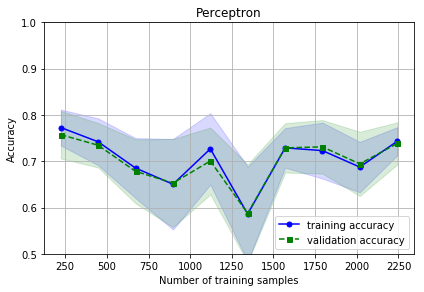

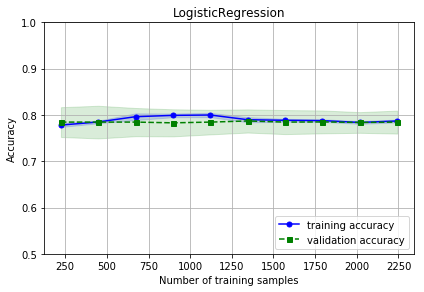

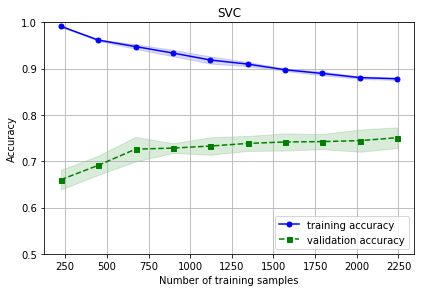

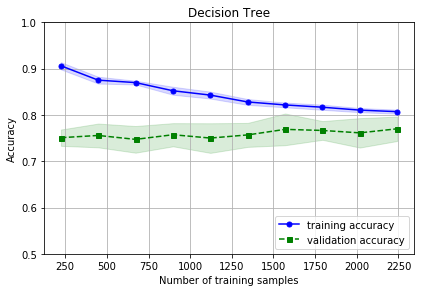

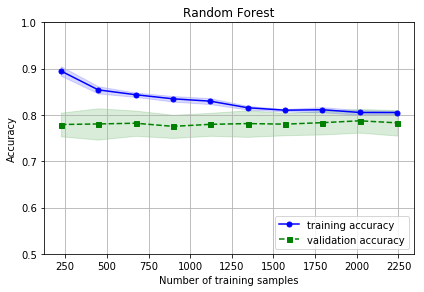

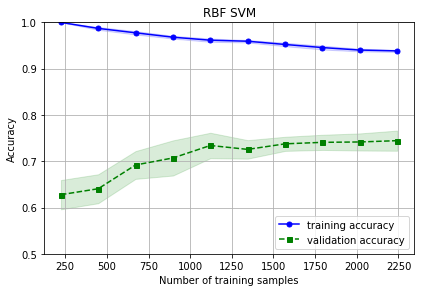

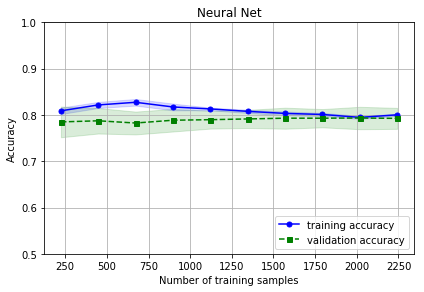

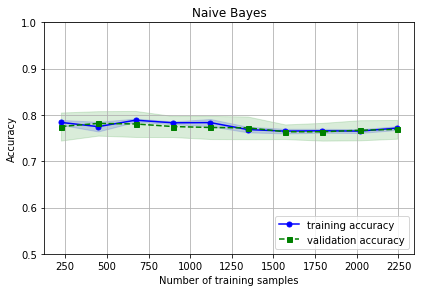

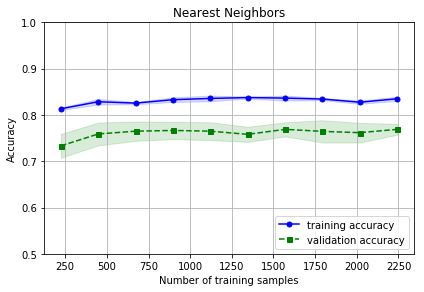

[None, None, None, None, None, None, None, None, None]

In [4]:
# learning curve
def lcurve(name, clf):
    pipe = Pipeline([('pca', PCA(n_components=5)), ('clf', clf)])
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator=pipe, X=X_train, y=y_train,
                       train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, color='blue', marker='o',
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std,
                     train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--',
             marker='s', markersize=5, label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std,
                     test_mean - test_std, alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.5, 1])
    plt.tight_layout()
    plt.title(name)
    plt.savefig("learning-curve-" + name + ".png", dpi=300)
    plt.show()


list(map(lcurve, names, classifiers))